### Ver. 2.0

In [1]:
import unittest

import numpy as np
import pandas as pd
import sklearn as skl

from collections import defaultdict

from matplotlib import pyplot as plt
from abc import ABCMeta, abstractmethod, abstractproperty

%matplotlib inline


class DBValue():
    def __init__(self, data):
        self.bucket_time, self.bucket_size, self.bucket_name, self.bucket_value, self.bucket_type = data
        self.bucket_time = int(self.bucket_time)
        self.bucket_size = int(self.bucket_size)
        self.bucket_value = float(self.bucket_value)
    
    @classmethod
    def from_db_string(cls, db_string):
        FIELD_NUMBER = 5
        fields = db_string.split("|")
        if len(fields) != FIELD_NUMBER:
            raise ValueError("{} fields expected, but got {}".format(FIELD_NUMBER, len(fields)))
        return cls(fields)
    
    def __str__(self):
        fieldnames = ["bucket_time", "bucket_size", "bucket_name", "bucket_value", "bucket_type"]
        fields = [self.bucket_time, self.bucket_size, self.bucket_name, self.bucket_value, self.bucket_type]
        return "\n".join(["{db value"] + ["{}: {}".format(fieldname, field) for field, fieldname in zip(fields, fieldnames)] + ["}"])


# example
#EXAMPLE_DB_STRING = "1506376740|60|lib.atoms.get|11.0|counter"
#print(DBValue.from_db_string(EXAMPLE_DB_STRING))

/Users/cnst/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
class IntervalBase():
    __metaclass__ = ABCMeta
    @abstractproperty
    def size(self):
        raise NotImplementedError
    
    @abstractproperty
    def value(self):
        raise NotImplementedError
    
    @abstractmethod
    def trim(self, start=None, end=None):
        raise NotImplementedError


class Interval(IntervalBase):
    def __init__(self, start, end, value=0.0, part=1.0, fake=False):
        self._start = start
        self._end = end
        self._value = value
        self._part = part
        self._fake = fake
        return
    
    @property
    def size(self):
        assert(self._end > self._start)
        return self._end - self.start
    
    @property
    def value(self):
        return self._value * self._part
    
    @property
    def start(self):
        return self._start
    
    @property
    def end(self):
        return self._end
    
    def trim(self, start=None, end=None):
        if start is None:
            start = self._start
        if end is None:
            end = self._end
        new_start = max(self._start, start)
        new_end = min(self._end, end)
        assert(new_start <= new_end)
        #assert(self.size > 0)
        if self.size > 0:
            part = self._part * ((new_end - new_start) / self.size)
        else:
            part = 0.0
        return Interval(new_start, new_end, self._value, part, self._fake)
    

    def split(self, coord):
        if self._start >= coord or self._end <= coord:
            raise ValueError("split coordinate must lie in [{}, {}) interval, but has value of {}"\
                             .format(self._start, self._end, coord))
        first_part = self._part * ((coord - self._start) / self.size)
        second_part = self._part - first_part
        return (Interval(self._start, coord, self._value, first_part, self._fake),
                Interval(coord, self._end, self._value, second_part, self._fake))
    
    def __repr__(self):
        return "[{}, {}]({}, {}, {})".format(self._start, self._end, self._value, self._part, self._fake)


class Point(IntervalBase):
    def __init__(self, coord, value=0.0):
        self._coord = coord
        self._value = value
        # it will behave like an very small interval
        self._end = np.nextafter(self._coord, self._coord + 1)
    
    @property
    def value(self):
        return self._value
    
    @property
    def coord(self):
        return self._coord
    
    @property
    def size(self):
        return 0.0
    
    @property
    def start(self):
        return self._coord
    
    @property
    def end(self):
        return self._end
    
    def trim(self, start=None, end=None):
        # no trimming for point
        return self
    
    def __repr__(self):
        return "[{}, {}]".format(self._coord, self._value)

In [3]:
class AggregatorBase():
    __metaclass__ = ABCMeta

    def __init__(self):
        self._agg_func = None
        self._default_agg_func_value = None

    @property
    def agg_func(self):
        return self._agg_func
        
    @property
    def default_agg_func_value(self):
        return self._default_agg_func_value
    
    @abstractmethod
    def aggregate(self, data):
        if len(data) > 0:
            return [self._agg_func(data_part) if len(data_part) > 0 else self._default_agg_func_value for data_part in data]
        else:
            return self._default_agg_func_value

class CounterAggregator(AggregatorBase):
    def __init__(self):
        super().__init__()
        self._agg_func = np.sum
        self._default_agg_func_value = 0


class AverageAggregator(AggregatorBase):
    def __init__(self):
        super().__init__()
        self._agg_func = np.average
        self._default_agg_func_value = 0


class PointAverageAggregator(AggregatorBase):
    def __init__(self):
        super().__init__()
        self._agg_func = np.average
        self._default_agg_func_value = 0


class CustomAggregator(AggregatorBase):
    def __init__(self, agg_func, default_agg_func_value):
        super().__init__()
        self._agg_func = agg_func
        self._default_agg_func_value = default_agg_func_value


class AggregatorFactory():
    # This is the factory method
    @staticmethod
    def get_aggregator(bucket_type, **kwargs):
        if bucket_type == 'counter':
            return CounterAggregator()
        elif bucket_type == 'average':
            return AverageAggregator()
        elif bucket_type == 'datapoint':
            return PointAverageAggregator()
        else:
            # default behavious for unknown bucket_type is averaging
            agg_func = kwargs.get('agg_func', np.average)
            default_agg_func_value = kwargs.get('default_agg_func_value', 0)
            return CustomAggregator(agg_func, default_agg_func_value)

In [4]:
class Timeline():
    def __init__(self, intervals, start=None, end=None, default=0):
        self._intervals = sorted(intervals, key=lambda d: d.start)
        self._start = self._intervals[0].start if start is None else start
        self._end = self._intervals[-1].end if end is None else end
        self._default = 0
        
    @property
    def start(self):
        return self._start
    
    @property
    def end(self):
        return self._end
    
    def take_next_bucket(self, intervals, bucket_size, bucket_start):
        bucket_end = bucket_size + bucket_start
        bucket = []
        if len(intervals) == 0:
            return bucket, intervals
        for i, interval in enumerate(intervals):
            if bucket_start > interval.start: # Invariance: interval.start < bucket_start
                if bucket_start >= interval.end:
                    # 1. interval lies completely before a bucket -- pass this interval
                    continue
                elif bucket_end >= interval.end:
                    # 2. interval lies within a bucket partially (second part)
                    first_part, second_part = interval.split(bucket_start)
                    bucket.append(second_part)
                    continue
                else:
                    # 3. interval surrounds bucket completely
                    first_part, second_part = interval.split(bucket_start)
                    second_part, third_part = second_part.split(bucket_end)
                    bucket.append(second_part)
                    return bucket, [third_part] + intervals[i + 1:]
            else:
                if bucket_end >= interval.end: # Invariance: interval.start >= bucket_start
                    # 1. interval lies within a bucket completely
                    bucket.append(interval.value)
                    continue
                elif bucket_end > interval.start:
                    # 2. interval lies within a bucket partially (first part)
                    first_part, second_part = interval.split(bucket_end)
                    bucket.append(first_part.value)
                    return bucket, [second_part] + intervals[i + 1:]
                else:
                    # 3. interval lies completely after a bucket
                    return bucket, intervals[i:]
        return bucket, list()
        
    def group_into_buckets(self, bucket_size, start=None, end=None):
        start = self.start if start is None else start
        end = self.end if end is None else end
        
        buckets = []
        
        if start >= end:
            return buckets
        
        intervals = self._intervals
        
        for bucket_start in range(start, end, bucket_size):
            next_bucket, intervals = self.take_next_bucket(intervals, bucket_size, bucket_start)
            buckets.append(next_bucket)
        
        return buckets

In [5]:
class BucketTimelineHandler():
    def __init__(self, bucket_name, bucket_type, db_values, aggregator=None, default=0):
        self._bucket_name = bucket_name
        self._bucket_type = bucket_type
        self._aggregator = aggregator if aggregator is not None else AggregatorFactory.get_aggregator(bucket_type)
        # sort db values by bucket_time
        self._db_values = sorted(db_values, key=lambda d: d.bucket_time)
        intervals = []
        for db_value in self._db_values:
            start = db_value.bucket_time
            end = db_value.bucket_time + db_value.bucket_size
            value = db_value.bucket_value
            if self._bucket_type == "datapoint":
                intervals.append(Point(start, value))
            else:
                intervals.append(Interval(start, end, value))
        self._timeline = Timeline(intervals=intervals, start=None, end=None, default=default)
    
    @property
    def start(self):
        return self._timeline.start
    
    @property
    def end(self):
        return self._timeline.end
    
    def group_into_buckets(self, bucket_size, start=None, end=None):
        return self._timeline.group_into_buckets(bucket_size, start, end)
    
    def stat(self, bucket_size, start=None, end=None):
        start = self.start if start is None else start
        end = self.end if end is None else end

        return self._aggregator.aggregate(self.group_into_buckets(bucket_size, start, end))

In [6]:
class BucketsManager():
    def __init__(self):
        self._handlers = {}
        
    def process(self, inputs):
        flatten_inputs = sum(inputs, [])
        bucket_dict = defaultdict(lambda: [])
        for dbvalue in map(DBValue.from_db_string, flatten_inputs):
            bucket_dict[dbvalue.bucket_name].append(dbvalue)
        
        for bucket_name, db_values in bucket_dict.items():
            bucket_type = db_values[0].bucket_type
            self._handlers[bucket_name] = BucketTimelineHandler(bucket_name=bucket_name,
                                                               bucket_type=bucket_type,
                                                               db_values=db_values,
                                                               aggregator=AggregatorFactory.get_aggregator(bucket_type))
    
    def stat_bucket(self, bucket_name, bucket_size, start=None, end=None):
        return self._handlers[bucket_name].stat(bucket_size, start, end)
    
    def stat(self, bucket_size, start, end):
        granulated = list(range(start, end, bucket_size))
        result = {'buckets': granulated, 'values': {}}
        for bucket_name in self._handlers.keys():
            result['values'][bucket_name] = self.stat_bucket(bucket_name, bucket_size, start, end)
        return result

    def bucket_names(self):
        return list(sorted(self._handlers.keys()))

In [7]:
db_result = """
1506376740|60|lib.atoms.get|11.0|counter

1506376800|60|lib.atoms.get|12.0|counter

1506377520|60|lib.atoms.get|11.0|counter

1506377580|60|lib.atoms.get|1.0|counter

1506377880|60|lib.atoms.get|24.0|counter

1506378660|60|lib.atoms.get|11.0|counter

1506378720|60|lib.atoms.get|1.0|counter
"""

db_values = list(map(DBValue.from_db_string, db_result.split("\n")[1::2]))

bucket_handler = BucketTimelineHandler(bucket_name=db_values[0].bucket_name,
                                       bucket_type=db_values[0].bucket_type,
                                       db_values=db_values,
                                       aggregator=AggregatorFactory.get_aggregator(db_values[0].bucket_type))

bucket_handler.stat(bucket_size=600, start=1506376200, end=1506386200)

[11.0, 12.0, 36.0, 0, 12.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

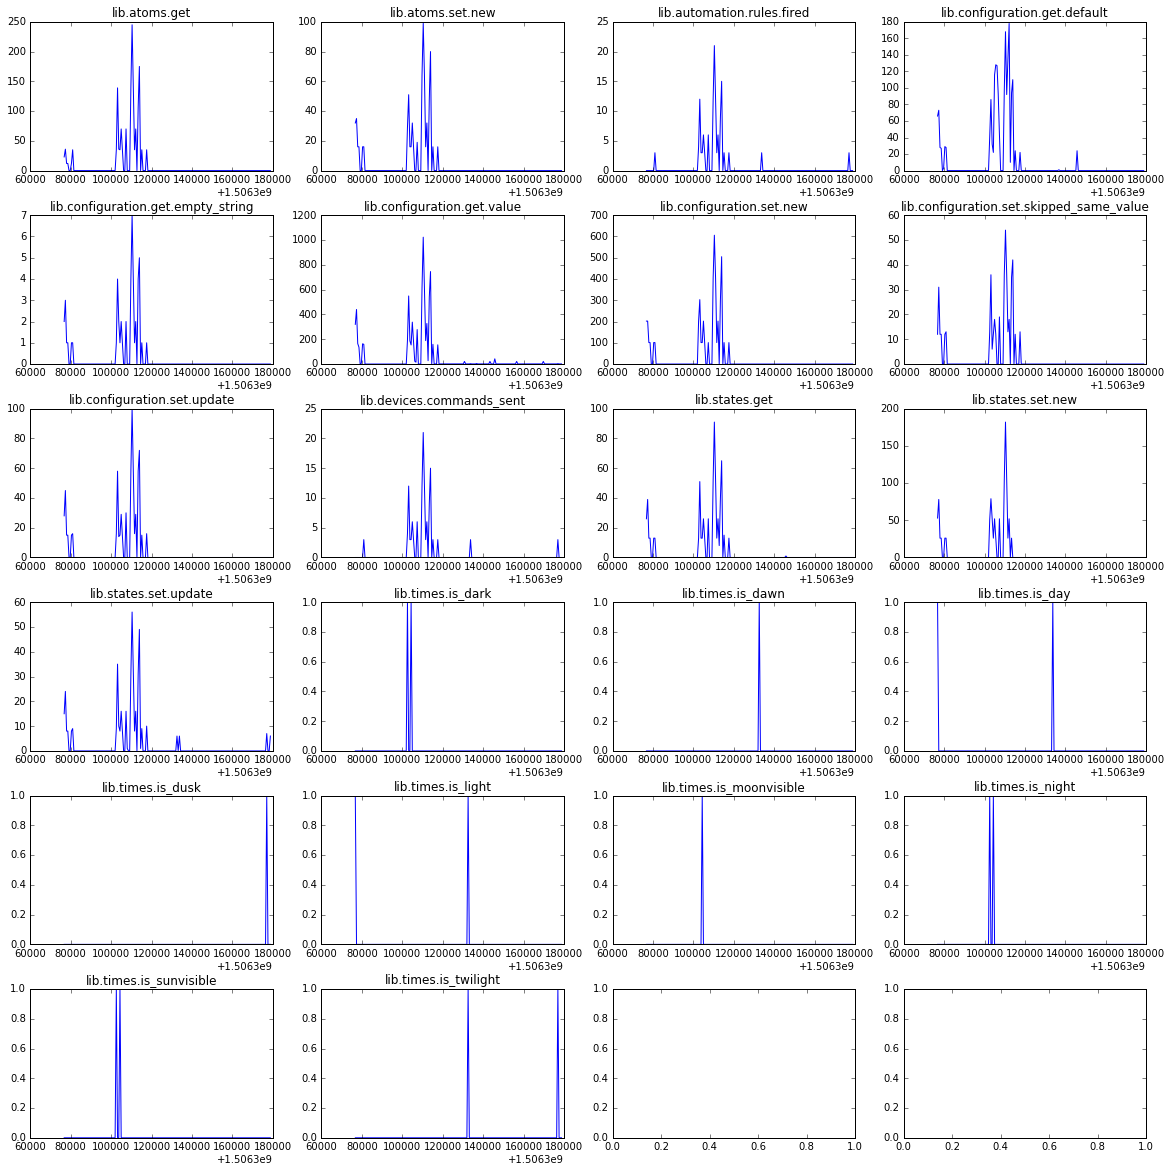

In [8]:
import sqlite3

def convert_as_query(df):
    return df.to_csv(sep='|', index=False).split("\n")[1:-1]

cnx = sqlite3.connect('../data/stats.db')
df = pd.read_sql_query("SELECT * FROM statistics", cnx)

df_part = df[['bucket_time', 'bucket_size', 'bucket_name', 'bucket_value', 'bucket_type']]

inputs = []
for bucket_name, df_bucket_name in df_part.groupby('bucket_name'):
    inputs.append(convert_as_query(df_bucket_name))
    
bm = BucketsManager()
bm.process(inputs)

data = bm.stat(bucket_size=600, start=1506376740, end=1506478920)
bucket_names = bm.bucket_names()

grid_width = 4
grid_height = len(bucket_names) // grid_width
grid_height += 1 if len(bucket_names) % grid_width != 0 else 0

grid_shape = (grid_height, grid_width)

f, axarr = plt.subplots(grid_height, grid_width, figsize=(20, 20))

for index, name in enumerate(bucket_names):
    i, j = np.unravel_index(index, dims=grid_shape)
    axarr[i, j].set_title(name)
    axarr[i, j].plot(data['buckets'], data['values'][name])

f.subplots_adjust(hspace=0.3, wspace=0.2)


#name = bm.bucket_names()[9]
#plt.title(name)
#plt.plot(data['buckets'], data['values'][name])

### Ver. 1.0

In [9]:
class Interval():
    def __init__(self, start, end, value=0.0, part=1.0, fake=False):
        self.start = start
        self.end = end
        self.value = value
        self.part = part
        self.fake = fake
        return
    
    @property
    def size(self):
        return self.end - self.start
    
    def apply(self, func):
        return func(self.start, self.end, self.value, self.part)
    
    def trim(self, start=None, end=None):
        if start is None:
            start = self.start
        if end is None:
            end = self.end
        new_start = max(self.start, start)
        new_end = min(self.end, end)
        assert(new_start <= new_end)
        #assert(self.size > 0)
        if self.size > 0:
            part = (new_end - new_start) / self.size
        else:
            part = 0.0
        return Interval(new_start, new_end, self.value, part, self.fake)
    
    def __repr__(self):
        return "[{}, {}]({}, {}, {})".format(self.start, self.end, self.value, self.part, self.fake)

In [10]:
def average(x):
    return np.mean(x)


class ContinuousIntervalAggregator():
    def __init__(self, bucket_type):
        if bucket_type == "counter":
            self.agg_type = "add"
        elif bucket_type == "average":
            self.agg_type = "avg"
        elif bucket_type == "datapoint":
            self.agg_type = "pavg"
        else:
            raise ValueError("bucket_type must be one of the [counter, average, datapoint], but got {} instead".format(bucket_type))
        self.bucket_type = bucket_type
        if self.agg_type == "add":
            self.agg_function = sum
        elif self.agg_type == "avg":
            self.agg_function = lambda x: average(x) if len(x) else 0
        elif self.agg_type == "pavg":
            self.agg_function = lambda x: average(x) if len(x) else 0
        return

    def aggregate(self, intervals, part_handling='scale'):
        def part_handle(value, part):
            if self.agg_type == "pavg":
                return value
            if part_handling == 'scale':
                return value * part
            elif part_handling == 'none':
                return value
            else:
                raise ValueError("part handling must be one of allowed strings")
        
        if intervals:
            if self.agg_type == "pavg":
                aggregated_value = self.agg_function([part_handle(interval.value, interval.part) for interval in intervals if not interval.fake])
            else:
                aggregated_value = self.agg_function([part_handle(interval.value, interval.part) for interval in intervals])
        else:
            aggregated_value = 0
        return aggregated_value

In [11]:
class Timeline():
    def __init__(self, intervals, interval_agg, start=None, end=None, default=0):
        self.intervals = sorted(intervals, key=lambda d: d.start)
        self.start = self.intervals[0].start if start is None else start
        self.end = self.intervals[-1].end if end is None else end
        self.default = 0
        self.interval_agg = interval_agg
    
    def fill_zeros(self):
        intervals = []
        last_end = self.start
        for interval in self.intervals:
            if interval.start > last_end:
                intervals.append(Interval(last_end, interval.start, self.default, fake=True))
            intervals.append(interval)
        if self.end > intervals[-1].end:
            intervals.append(Interval(intervals[-1].end, self.end, self.default, fake=True))
        self.intervals = intervals
    
    def stat(self, start, end):
        # find start place
        intervals = []
        for i, interval in enumerate(self.intervals):
            if interval.end >= start:
                intervals = self.intervals[i:]
                break
        for i, interval in enumerate(intervals):
            if interval.end >= end:
                if interval.start >= end:
                    intervals = intervals[:i]
                    break
                # handle zero-length interval with bound point
                if interval.end == end and len(intervals) > i + 1 and intervals[i+1].size == 0:
                    intervals = intervals[:i + 2]
                else:
                    intervals = intervals[:i + 1]
                break
        if len(intervals) > 0:
            intervals[0] = intervals[0].trim(start=start)
            intervals[-1] = intervals[-1].trim(end=end)
        return self.interval_agg(intervals)

In [12]:
class BucketHandler():
    def __init__(self, bucket_name, bucket_type, db_values, interval_agg, start=None, end=None, default=0):
        self.bucket_name = bucket_name
        self.bucket_type = bucket_type
        # sort db values by bucket_time
        self.db_values = sorted(db_values, key=lambda d: d.bucket_time)
        intervals = []
        for db_value in self.db_values:
            start = db_value.bucket_time
            end = db_value.bucket_time + db_value.bucket_size
            value = db_value.bucket_value
            intervals.append(Interval(start, end, value))
        
        self.timeline = Timeline(intervals=intervals, interval_agg=interval_agg, start=start, end=end, default=default)
        return
        
    def get_start_time(self):
        start_time = self.db_values[0].bucket_time
        return start_time
    
    def get_end_time(self):
        end_time = self.db_values[-1].bucket_time
        end_time += self.db_values[-1].bucket_size
        return end_time
    
    def time_granulate(self, resolution, start=None, end=None):
        if start is None:
            start = self.get_start_time()
        if end is None:
            end = self.get_end_time()
        current_start = start
        granulated = [current_start]
        while current_start <= end:
            current_start += resolution
            granulated.append(current_start)
        return granulated

        
    def stat(self, bucket_size, start=None, end=None):
        if start is None:
            start = self.get_start_time()
        if end is None:
            end = self.get_end_time()
        current_start = start
        stat_result = []
        while current_start < end:
            stat_result.append(self.timeline.stat(current_start, current_start + bucket_size))
            current_start += bucket_size
        if current_start == end:
            if self.bucket_type == "datapoint":
                stat_result.append(self.timeline.stat(current_start, end))
                #print('dp size: {}'.format(len(stat_result)))
            else:
                stat_result.append(stat_result[-1])
                #print('non dp size: {}'.format(len(stat_result)))
        stat_result = [stat_result[0]] + stat_result
        #print('ordinary size: {}'.format(len(stat_result)))
        #print('-'*80)
        return stat_result

In [13]:
class BucketsManager():
    def __init__(self):
        self.handlers = {}
    
    def process(self, inputs):
        flatten_inputs = sum(inputs, [])
        bucket_dict = defaultdict(lambda: [])
        for dbvalue in map(DBValue.from_db_string, flatten_inputs):
            bucket_dict[dbvalue.bucket_name].append(dbvalue)
        
        for bucket_name, db_values in bucket_dict.items():
            self.handlers[bucket_name] = BucketHandler(bucket_name=db_values[0].bucket_name,
                                                       bucket_type=db_values[0].bucket_type,
                                                       db_values=db_values,
                                                       interval_agg=ContinuousIntervalAggregator(db_values[0].bucket_type).aggregate)
        
    def stat_bucket_by_name(self, bucket_name, bucket_size, start=None, end=None):
        granulated = self.handlers[bucket_name].time_granulate(bucket_size, start=start, end=end)
        if not bucket_name in self.handlers.keys():
            raise ValueError("bucket_name should be one of {}, but got {}".format(list(self.handlers.keys()), bucket_name))
        return self.handlers[bucket_name].stat(bucket_size, start, end)
    
    def stat(self, bucket_size, start=None, end=None):
        bucket_name = list(self.handlers.keys())[0]
        granulated = self.handlers[bucket_name].time_granulate(bucket_size, start=start, end=end)
        result = {'buckets': granulated, 'values': {}}
        for bucket_name in self.handlers.keys():
            result['values'][bucket_name] = self.stat_bucket_by_name(bucket_name, bucket_size, start=start, end=end)
        return result
    
    def bucket_names(self):
        return list(sorted(self.handlers.keys()))

### BucketHandler simple test

In [14]:
db_result = """
1506376740|60|lib.atoms.get|11.0|counter

1506376800|60|lib.atoms.get|12.0|counter

1506377520|60|lib.atoms.get|11.0|counter

1506377580|60|lib.atoms.get|1.0|counter

1506377880|60|lib.atoms.get|24.0|counter

1506378660|60|lib.atoms.get|11.0|counter

1506378720|60|lib.atoms.get|1.0|counter
"""

db_values = list(map(DBValue.from_db_string, db_result.split("\n")[1::2]))

bucket_handler = BucketHandler(bucket_name=db_values[0].bucket_name,
                               bucket_type=db_values[0].bucket_type,
                               db_values=db_values,
                               interval_agg=ContinuousIntervalAggregator(db_values[0].bucket_type).aggregate)

bucket_handler.stat(bucket_size=600, start=1506376200, end=1506386200)

[11.0, 11.0, 12.0, 36.0, 0, 12.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### BucketsManager simple test (on a given database file)

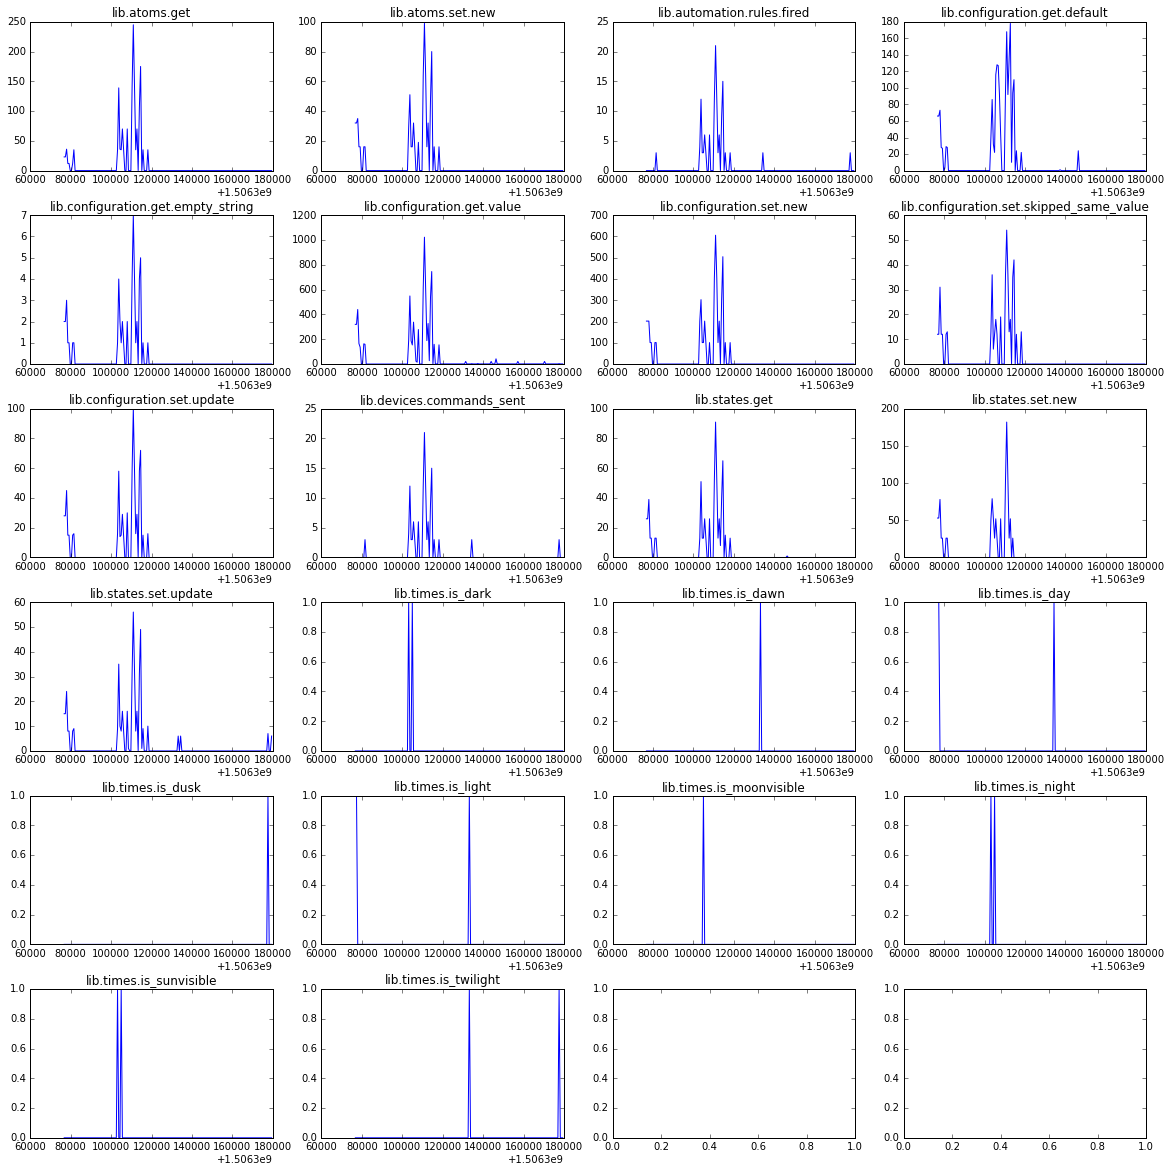

In [15]:
#import sqlite3

#def convert_as_query(df):
#    return df.to_csv(sep='|', index=False).split("\n")[1:-1]

#cnx = sqlite3.connect('stats.db')
pd.read_sql_query("SELECT * FROM statistics", cnx)

df_part = df[['bucket_time', 'bucket_size', 'bucket_name', 'bucket_value', 'bucket_type']]

inputs = []
for bucket_name, df_bucket_name in df_part.groupby('bucket_name'):
    inputs.append(convert_as_query(df_bucket_name))


bm = BucketsManager()
bm.process(inputs)

data = bm.stat(bucket_size=600, start=1506376740, end=1506478920)
bucket_names = bm.bucket_names()

grid_width = 4
grid_height = len(bucket_names) // grid_width
grid_height += 1 if len(bucket_names) % grid_width != 0 else 0

grid_shape = (grid_height, grid_width)

f, axarr = plt.subplots(grid_height, grid_width, figsize=(20, 20))

for index, name in enumerate(bucket_names):
    i, j = np.unravel_index(index, dims=grid_shape)
    axarr[i, j].set_title(name)
    axarr[i, j].plot(data['buckets'], data['values'][name])

f.subplots_adjust(hspace=0.3, wspace=0.2)


#name = bm.bucket_names()[9]
#plt.title(name)
#plt.plot(data['buckets'], data['values'][name])